# Dog Breed Classifier


## Step 1: Data Import


Download the following and save them in the path mentioned beside each for this notebook to work:
1. [ResNet50 Features](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) - '~/path/to/project/bottleneck_features/DogResnet50Data.npz'
2. [Dog Images](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip) - '~/path/to/project/dogImages/'
3. [Human Images](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip) - '~/path/to/project/lfw/'
4. Some random image of a human or non-human object in 'test_images/'

### Import Dog Data

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
% matplotlib inline

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
trainfile, traintargets = load_dataset('dogImages/train')
validfile, validtargets = load_dataset('dogImages/valid')
testfile, testtargets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([trainfile, validfile, testfile])))
print('There are %d training dog images.' % len(trainfile))
print('There are %d validation dog images.' % len(validfile))
print('There are %d test dog images.'% len(testfile))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Data

In [2]:
import random
random.seed(100)

# load filenames in shuffled human dataset
humanfile = np.array(glob("lfw/*/*"))
random.shuffle(humanfile)

# print statistics about the dataset
print('There are %d total human images.' % len(humanfile))

There are 13233 total human images.


## Step 2: Detect Humans

### Human Face Detector Function

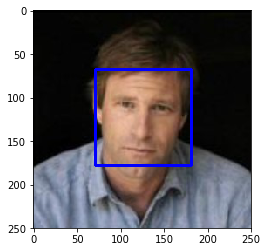

True

In [3]:
import cv2

def detect_face(img_path, display = False):
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    if display:
        for (x,y,w,h) in faces:
            # add bounding box to color image
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
            # convert BGR image to RGB for plotting
            cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # display the image, along with bounding box
            plt.imshow(cv_rgb)
            plt.show()
    return len(faces) > 0

# Test with a random face
detect_face('lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg', True)

### Testing accuracy of the face classifier

Let us use the humans and dogs dataset to find how accurately our face detector works.

In [4]:
human_files_short = humanfile[:100]
dog_files_short = trainfile[:100]

human_count = 0.0
total = 0.0
for img in human_files_short:
    isPerson = detect_face(img)
    if not isPerson:
        human_count += 1
total = 100 - human_count
percentage = (total/len(human_files_short)) * 100.0
print('Percentage of humans correctly classified as people: {}%'.format(percentage))

dog_count = 0.0
for img in dog_files_short:
    isPerson = detect_face(img)
    if isPerson:
        dog_count += 1
percentage = (dog_count/len(dog_files_short)) * 100.0
print('Percentage of dogs misclassified as people: {}%'.format(percentage))

Percentage of humans correctly classified as people: 99.0%
Percentage of dogs misclassified as people: 12.0%


## Step 3: Detect Dogs

We will use ResNet50 which is a pre-trained model to detect dogs in images. 

ResNet50 model comes in built with the Keras package.

In [5]:
from keras.applications.resnet50 import ResNet50
# Activate the resnet model with imagenet data
ResNet50_model = ResNet50(weights='imagenet')

### Pre Process data

In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # Load the image with a size of 224x224 using Keras's load_img module
    img = image.load_img(img_path, target_size=(224, 224))
    # Reshpae to (224, 224, 3) to show the RGB layer in the end
    x = image.img_to_array(img)
    # Reshape to include batches as well
    return np.expand_dims(x, axis=0)

In [7]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [8]:
def detect_dog(img_path):
    prediction = ResNet50_predict_labels(img_path)
    
    return ((prediction <= 268) & (prediction >= 151))

In [9]:
human_count = 0.0

for img in tqdm(human_files_short):
    isDog = detect_dog(img)
    if isDog:
        human_count += 1
    percentage = (human_count/len(human_files_short)) * 100
print('Percentage of humans misclassified as dogs:: {}%'.format(percentage))

dog_count = 0.0
for img in tqdm(dog_files_short):
    isDog = detect_dog(img)
    if isDog:
        dog_count += 1
    percentage = (dog_count/len(dog_files_short)) * 100
print('Percentage of dogs correctly classified as dogs: {}%'.format(percentage))

  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of humans misclassified as dogs:: 2.0%


100%|██████████| 100/100 [00:26<00:00,  3.80it/s]

Percentage of dogs correctly classified as dogs: 100.0%


## Step 4: Transfer Learning


In [11]:
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train = bottleneck_features['train']
valid = bottleneck_features['valid']
test = bottleneck_features['test']

In [12]:
from keras import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D, Flatten
from keras import regularizers

model = Sequential()
model.add(Flatten(input_shape=train.shape[1:]))
model.add(Dense(len(dog_names), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='rmsprop', metrics=['accuracy'], loss='categorical_crossentropy')

from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train, train_targets, 
          validation_data=(valid, valid_targets),
          epochs=20, batch_size=10, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s 665us/step - loss: 1.5821 - acc: 0.6139 - val_loss: 0.9941 - val_acc: 0.7257
Epoch 2/20
6680/6680 [==============================] - 3s 397us/step - loss: 0.5351 - acc: 0.8533 - val_loss: 0.8737 - val_acc: 0.7665
Epoch 3/20
6680/6680 [==============================] - 3s 397us/step - loss: 0.3843 - acc: 0.9001 - val_loss: 0.8010 - val_acc: 0.7844
Epoch 4/20
6680/6680 [==============================] - 3s 400us/step - loss: 0.3015 - acc: 0.9226 - val_loss: 0.8056 - val_acc: 0.7880
Epoch 5/20
6680/6680 [==============================] - 3s 409us/step - loss: 0.2480 - acc: 0.9404 - val_loss: 0.8875 - val_acc: 0.7820
Epoch 6/20
6680/6680 [==============================] - 3s 411us/step - loss: 0.2131 - acc: 0.9516 - val_loss: 0.8769 - val_acc: 0.8024
Epoch 7/20
6680/6680 [==============================] - 3s 459us/step - loss: 0.1890 - acc: 0.9603 - val_loss: 0.9256 - val_acc: 0.8132
E

### Accuracy Test


In [14]:
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test]


test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.0000%


## Step 5: Predicts



In [15]:
def predict_breed(img_path):
    from keras.applications.resnet50 import ResNet50, preprocess_input
    bottleneck_feature = ResNet50(weights='imagenet', 
                                  include_top=False).predict(preprocess_input(path_to_tensor(img_path)))
    predicted_vector = model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def predict_dog_breed(img_path):
    is_dog = detect_dog(img_path)
    is_human = detect_face(img_path)
    if is_dog:
        return "Dog Breed: {}".format(predict_breed(img_path))
    elif is_human:
        return "Human Resembles: {}".format(predict_breed(img_path))
    else:
        return 'Error: Neither Human nor Dog Detected'

def run_image_scan(img_path):
    img = cv2.imread(img_path)
    label = predict_dog_breed(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(label)
    plt.show()

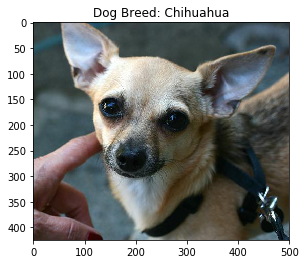

In [16]:
run_image_scan('dogImages/train/048.Chihuahua/Chihuahua_03398.jpg')